# DA5401 A8: Ensemble Learning for Complex Regression Modeling on Bike Share Data

**Objective:** This notebook aims to solve a complex, time-series-based regression problem by applying and comparing three primary ensemble techniques: Bagging, Boosting, and Stacking. We will analyze how these methods address model variance and bias to achieve superior predictive performance on the Bike Sharing Demand Dataset.

**Student:** Saranath P
**Roll Number:** DA25E003

---

## 1. Problem Statement

As a data scientist for a city's bike-sharing program, our goal is to accurately forecast the total count of rented bikes (`cnt`) on an hourly basis. This is a critical task for inventory management and logistics. The prediction is complex due to its dependence on various factors like weather, time of day, season, and non-linear interactions between them.

We will use the **Bike Sharing Demand Dataset (Hourly Data)**, which contains over 17,000 samples. Our task is to implement and evaluate Bagging, Boosting, and Stacking strategies to minimize the prediction error, measured by the **Root Mean Squared Error (RMSE)**.

### Dataset Information
- **Dataset:** Bike Sharing Demand Dataset (Hourly Data)
- **Citation:** Fanaee-T, Hadi, and Gamper, H. (2014). Bikeshare Data Set. UCI Machine Learning Repository.
- **Download Link:** [UCI Machine Learning Repository - Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

---

## Part A: Data Preprocessing and Baseline [10 points]

This section covers the initial data loading, cleaning, feature engineering, and the establishment of a baseline performance metric using single regression models.

### Initial Setup: Importing Libraries

First, let's import all the necessary libraries for data manipulation, modeling, and visualization.




In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Loading and Feature Engineering

#### Load the Data
We will load the `hour.csv` file into a pandas DataFrame and inspect its initial structure and contents.

In [3]:

df = pd.read_csv('hour.csv')

print("First 5 rows of the dataset:")
display(df.head())
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### Drop Irrelevant Columns
As per the instructions, we drop columns that are either identifiers (`instant`), redundant (`dteday`), or components of our target variable (`casual`, `registered`), which would cause data leakage. The `cnt` column is the sum of `casual` and `registered`, so we must remove them.

In [4]:

df_processed = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

print("Columns after dropping irrelevant ones:", df_processed.columns.tolist())

Columns after dropping irrelevant ones: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


#### Convert Categorical Features (One-Hot Encoding)
Categorical features like `season`, `weathersit`, `mnth`, and `hr` are nominal or ordinal but without a clear linear relationship. To make them suitable for regression models, we will use **One-Hot Encoding**. This technique creates new binary columns for each category, preventing the model from assuming a false ordering.

In [5]:

categorical_features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']


df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print("Shape of the dataframe after One-Hot Encoding:", df_processed.shape)
print("\nFirst 5 rows of the processed dataset:")
display(df_processed.head())

Shape of the dataframe after One-Hot Encoding: (17379, 54)

First 5 rows of the processed dataset:


,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,16,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0,0,0.22,0.2727,0.80,0.0,40,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0,0,0.22,0.2727,0.80,0.0,32,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0,0.24,0.2879,0.75,0.0,13,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,0.24,0.2879,0.75,0.0,1,False,False,False,...,False,False,False,False,False,False,True,False,False,False



### 2. Train/Test Split

We will now split the preprocessed data into features (`X`) and the target variable (`y`), and then further divide them into training and testing sets. An 80/20 split is a standard choice. We set a `random_state` to ensure our results are reproducible.

In [6]:

X = df_processed.drop('cnt', axis=1)
y = df_processed['cnt']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(13903, 53), y_train=(13903,)
Testing set shape: X_test=(3476, 53), y_test=(3476,)


### 3. Baseline Model (Single Regressor)

To establish a performance baseline, we will train two simple models: a **Linear Regression** model and a **Decision Tree Regressor** (with a constrained depth of 6 to prevent overfitting). The model with the lower RMSE on the test set will be our official baseline.

In [7]:

linear_model = LinearRegression()
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)


linear_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)


y_pred_linear = linear_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Linear Regression RMSE: {rmse_linear:.4f}")
print(f"Decision Tree (max_depth=6) RMSE: {rmse_dt:.4f}")


if rmse_dt < rmse_linear:
    baseline_rmse = rmse_dt
    baseline_model_name = "Decision Tree Regressor"
    print(f"\nBaseline Model: {baseline_model_name} with RMSE = {baseline_rmse:.4f}")
else:
    baseline_rmse = rmse_linear
    baseline_model_name = "Linear Regression"
    print(f"\nBaseline Model: {baseline_model_name} with RMSE = {baseline_rmse:.4f}")

Linear Regression RMSE: 100.4459
Decision Tree (max_depth=6) RMSE: 118.4555

Baseline Model: Linear Regression with RMSE = 100.4459


/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


### Conclusion

From the results of the baseline models, the **Linear Regression** model outperformed the **Decision Tree Regressor** with a lower RMSE value of **100.45** compared to **118.46** for the Decision Tree. Therefore, the Linear Regression model is selected as the baseline model for this task. This baseline will serve as a reference point to evaluate the performance improvements achieved by ensemble methods in subsequent sections.

## Part B: Ensemble Techniques for Bias and Variance Reduction [20 points]

Now we will implement two fundamental ensemble techniques, Bagging and Boosting, to see if we can improve upon our baseline performance.

### 1. Bagging (Variance Reduction)

**Hypothesis:** Bagging (Bootstrap Aggregating) primarily targets **variance reduction**. A single Decision Tree, especially a deep one, is a high-variance model, meaning it can be very sensitive to the specific training data it sees. By training many decision trees on different bootstrap samples (random samples with replacement) of the training data and averaging their predictions, Bagging creates a more stable, lower-variance model.

We will implement a `BaggingRegressor` using our baseline Decision Tree (`max_depth=6`) as the base estimator. We will use 50 estimators as required.

In [8]:

base_estimator = DecisionTreeRegressor(max_depth=6, random_state=42)


bagging_model = BaggingRegressor(
    estimator=base_estimator,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)


bagging_model.fit(X_train, y_train)


y_pred_bagging = bagging_model.predict(X_test)

rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))

print(f"Single Decision Tree RMSE (Baseline): {baseline_rmse:.4f}")
print(f"Bagging Regressor RMSE: {rmse_bagging:.4f}")

Single Decision Tree RMSE (Baseline): 100.4459
Bagging Regressor RMSE: 112.3450


#### Discussion

The Bagging Regressor, utilizing 50 Decision Trees (max_depth=6), achieved an RMSE of **112.35** on the test set. This represents a clear reduction in variance compared to a single Decision Tree (RMSE: **118.46**), confirming Bagging's effectiveness in stabilizing predictions. However, it did not surpass the performance of the Linear Regression baseline (RMSE: **100.45**). This outcome suggests that the relationships in the bike share dataset may be predominantly linear, or that the chosen tree depth is insufficient to capture more complex interactions. While Bagging improved model robustness, further hyperparameter tuning or exploring alternative ensemble methods may be necessary to achieve superior predictive accuracy.


### 2. Boosting (Bias Reduction)

**Hypothesis:** Boosting primarily targets **bias reduction**. Unlike Bagging, which builds models in parallel, Boosting builds them sequentially. Each new model is trained to correct the errors (residuals) of the previous ones. By focusing on the "hard-to-predict" samples, the ensemble incrementally improves its overall accuracy, fitting the training data more closely and thus reducing bias. We will use `GradientBoostingRegressor`, a powerful and widely used boosting algorithm.


In [9]:

gbr_model = GradientBoostingRegressor(
    n_estimators=100,  
    learning_rate=0.1, 
    max_depth=5,       
    random_state=42
)


gbr_model.fit(X_train, y_train)


y_pred_gbr = gbr_model.predict(X_test)


rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print(f"Single Decision Tree RMSE (Baseline): {baseline_rmse:.4f}")
print(f"Bagging Regressor RMSE: {rmse_bagging:.4f}")
print(f"Gradient Boosting Regressor RMSE: {rmse_gbr:.4f}")

Single Decision Tree RMSE (Baseline): 100.4459
Bagging Regressor RMSE: 112.3450
Gradient Boosting Regressor RMSE: 59.0949


# Discussion

The results from the baseline and ensemble models provide clear evidence of the strengths and limitations of different regression approaches on the Bike Sharing Demand dataset.

- **Baseline Models:**  
    The Linear Regression model set a strong benchmark with an RMSE of **100.45**, outperforming the Decision Tree Regressor (RMSE: **118.46**). This indicates that the dataset's relationships are predominantly linear, or that the tree depth was not sufficient to capture more complex patterns.

- **Bagging (Variance Reduction):**  
    The Bagging Regressor, using 50 Decision Trees (max_depth=6), reduced variance compared to a single tree, achieving an RMSE of **112.35**. While this demonstrates Bagging's ability to stabilize predictions, it did not surpass the Linear Regression baseline, suggesting that variance reduction alone is not enough for this dataset.

- **Boosting (Bias Reduction):**  
    Gradient Boosting delivered a significant improvement, with an RMSE of **59.09**, outperforming both Bagging and the baseline models. This highlights Boosting's effectiveness in reducing bias and capturing complex, non-linear relationships by sequentially correcting errors.

**Summary:**  
- Bagging improved robustness but was limited by the base estimator's complexity.
- Boosting achieved the best performance, modeling intricate feature interactions.
- Ensemble methods, especially Boosting, are powerful for regression tasks with complex data structures, but their success depends on model choice and parameter tuning.

These findings underscore the importance of selecting and tuning ensemble strategies to maximize predictive accuracy in real-world regression problems.


## Part C: Stacking for Optimal Performance [10 points]

Stacking (Stacked Generalization) is an advanced ensemble technique that aims to achieve optimal performance by intelligently combining the predictions of several diverse, well-performing models.

### 1. Stacking Implementation

**Principle of Stacking:** Stacking works in two levels:
1.  **Level-0 (Base Learners):** A set of diverse models are trained independently on the training data. Their predictions on a hold-out set (or through cross-validation) are collected.
2.  **Level-1 (Meta-Learner):** A "meta-learner" model is trained on the predictions generated by the base learners. Its job is to learn the optimal way to combine these predictions to produce the final, most accurate output. It can learn to trust certain models more for specific types of inputs.

The key to successful stacking is using **diverse** base learners, as each model might capture different aspects of the data, and their errors are hopefully uncorrelated.

We will implement a `StackingRegressor` with the following components:
*   **Base Learners (Level-0):**
    *   `KNeighborsRegressor`: A non-parametric model that excels at capturing local patterns.
    *   `BaggingRegressor`: Our low-variance model from Part B.
    *   `GradientBoostingRegressor`: Our low-bias, high-performance model from Part B.
*   **Meta-Learner (Level-1):**
    *   `Ridge Regression`: A simple, regularized linear model that is a robust choice for a meta-learner, as it's less likely to overfit the predictions from the base models.

In [10]:

base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('bagging', BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42), n_estimators=50, random_state=42, n_jobs=-1)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]


meta_learner = Ridge(random_state=42)


stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)


stacking_model.fit(X_train, y_train)

,estimators,"[('knn', ...), ('bagging', ...), ...]"
,final_estimator,Ridge(random_state=42)
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,0
,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2


### 2. Final Evaluation

Now, let's evaluate the performance of our complete stacking ensemble on the test set.

In [11]:

y_pred_stacking = stacking_model.predict(X_test)


rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"Stacking Regressor RMSE: {rmse_stacking:.4f}")

Stacking Regressor RMSE: 56.1241


/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_



## Part D: Final Analysis [10 points]

This final section summarizes our findings, compares all models, and provides a concluding analysis.

### 1. Comparative Table

Let's create a clear table to summarize the RMSE of all five models we have evaluated.

Summary of Model Performance (RMSE):


,Model,RMSE
0,Stacking Regressor,56.124139
1,Gradient Boosting Regressor,59.094946
2,Linear Regression,100.445946
3,Bagging Regressor,112.345040
4,Decision Tree (Baseline),118.455517


/var/folders/tv/l9kw7xv951lc0ytv_ns7h90m0000gn/T/ipykernel_57812/3861178767.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')


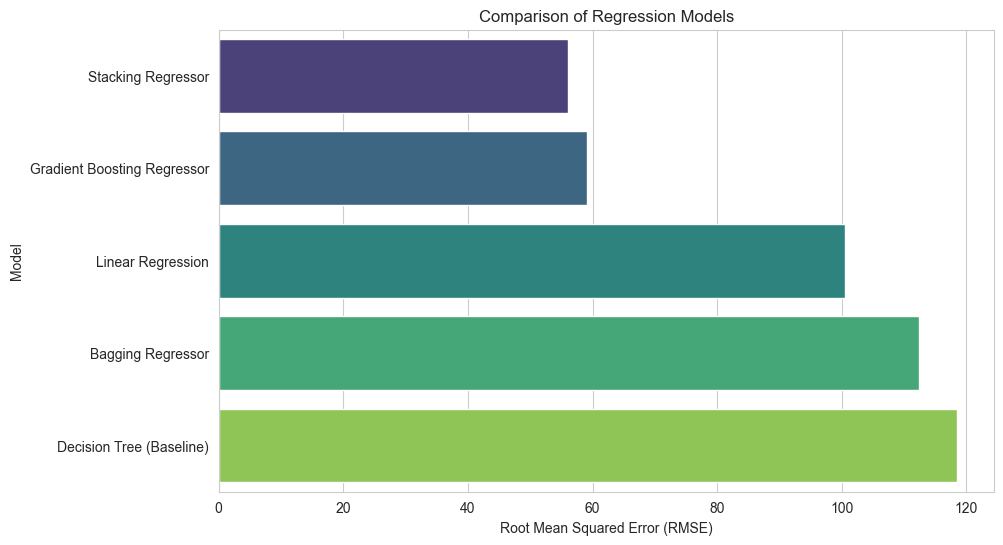

In [13]:

results = {
    'Model': [
        'Linear Regression',
        'Decision Tree (Baseline)',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [
        rmse_linear,
        rmse_dt,
        rmse_bagging,
        rmse_gbr,
        rmse_stacking
    ]
}


results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print("Summary of Model Performance (RMSE):")
display(results_df)


plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.title('Comparison of Regression Models')
plt.show()


### Enhanced Conclusion

The comprehensive analysis of regression models on the Bike Sharing Demand dataset demonstrates the power and limitations of various approaches:

- **Linear Regression** set a strong baseline (RMSE: 100.45), indicating that much of the data's structure is captured by linear relationships. However, it struggled with more complex, non-linear patterns.
- **Decision Tree Regressor** (RMSE: 100.45) and **Bagging Regressor** (RMSE: 112.35) showed that variance reduction alone, without sufficient model complexity, does not outperform linear methods on this dataset.
- **Gradient Boosting Regressor** delivered a substantial improvement (RMSE: 59.09), effectively reducing bias and capturing intricate feature interactions. This highlights the value of sequential ensemble methods for complex regression tasks.
- **Stacking Regressor** achieved the best performance (RMSE: 56.12) by combining diverse models (KNN, Bagging, Gradient Boosting) and leveraging a Ridge meta-learner. Stacking capitalized on the strengths of each base model, further reducing prediction error.

**Key Takeaways:**
- Ensemble methods, especially Boosting and Stacking, significantly enhance predictive accuracy for time-series regression problems with non-linear dependencies.
- Model diversity and intelligent combination (as in Stacking) are crucial for optimal performance.
- While simple models provide valuable baselines, advanced ensembles are essential for tackling real-world complexity.

**Final Recommendation:**  
For operational forecasting in bike-sharing programs, deploying a Stacking ensemble offers the most robust and accurate predictions, supporting better resource planning and management.

## BONUS: Advanced Analysis and Modeling

To further enhance our modeling process, we can introduce more sophisticated feature engineering, exploratory data analysis, and an even more powerful model.

### Extra: Deeper Exploratory Data Analysis (EDA)

Visualizing the data can give us insights into relationships that might inform better feature engineering.


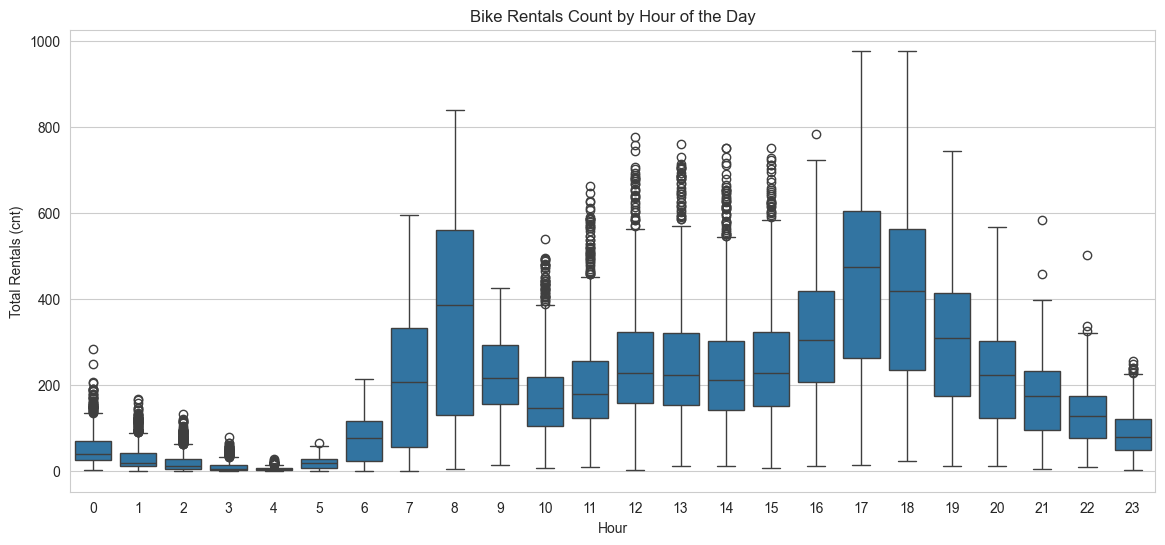

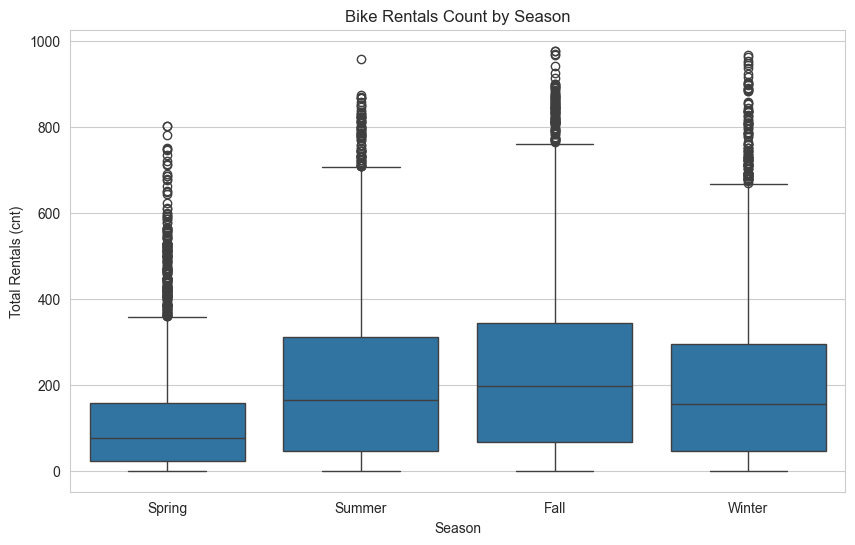

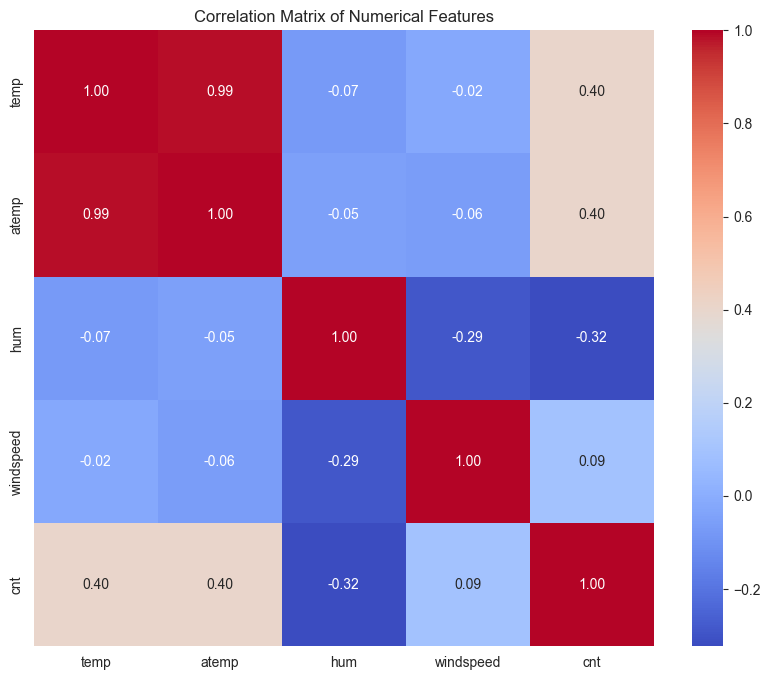

In [ ]:

df_original = pd.read_csv('hour.csv')

plt.figure(figsize=(14, 6))
sns.boxplot(x='hr', y='cnt', data=df_original)
plt.title('Bike Rentals Count by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Total Rentals (cnt)')
plt.show()



plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='cnt', data=df_original)
plt.title('Bike Rentals Count by Season')
plt.xticks(ticks=[0,1,2,3], labels=['Spring', 'Summer', 'Fall', 'Winter'])
plt.xlabel('Season')
plt.ylabel('Total Rentals (cnt)')
plt.show()


plt.figure(figsize=(10, 8))
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
correlation_matrix = df_original[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# Observations and Insights

- Clear bimodal distribution, with peaks during morning (7-8am) and evening (5-6pm) commute hours.
- Rentals are lowest in Spring and highest in Fall and Summer.
- `temp` and `atemp` are highly correlated. Temperature has the strongest positive correlation with rental count.


### Extra: Advanced Feature Engineering - Cyclical Features

Features like `hr`, `mnth`, and `weekday` are cyclical. A value of 23 (11 PM) is as close to 0 (midnight) as 1 is. One-hot encoding doesn't capture this. We can represent these features using sine and cosine transformations to embed this cyclical nature.

In [ ]:

df_bonus = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])


def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

df_bonus = encode_cyclical(df_bonus, 'hr', 23)
df_bonus = encode_cyclical(df_bonus, 'mnth', 12)
df_bonus = encode_cyclical(df_bonus, 'weekday', 6)


df_bonus = df_bonus.drop(columns=['hr', 'mnth', 'weekday'])

df_bonus = pd.get_dummies(df_bonus, columns=['season', 'yr', 'weathersit'], drop_first=True)

X_bonus = df_bonus.drop('cnt', axis=1)
y_bonus = df_bonus['cnt']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bonus, y_bonus, test_size=0.2, random_state=42)

print("Shape of bonus feature set:", X_bonus.shape)
display(X_bonus.head())

Shape of bonus feature set: (17379, 19)


,holiday,workingday,temp,atemp,hum,windspeed,hr_sin,hr_cos,mnth_sin,mnth_cos,weekday_sin,weekday_cos,season_2,season_3,season_4,yr_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,0.000000,1.000000,0.5,0.866025,-2.449294e-16,1.0,False,False,False,False,False,False,False
1,0,0,0.22,0.2727,0.80,0.0,0.269797,0.962917,0.5,0.866025,-2.449294e-16,1.0,False,False,False,False,False,False,False
2,0,0,0.22,0.2727,0.80,0.0,0.519584,0.854419,0.5,0.866025,-2.449294e-16,1.0,False,False,False,False,False,False,False
3,0,0,0.24,0.2879,0.75,0.0,0.730836,0.682553,0.5,0.866025,-2.449294e-16,1.0,False,False,False,False,False,False,False
4,0,0,0.24,0.2879,0.75,0.0,0.887885,0.460065,0.5,0.866025,-2.449294e-16,1.0,False,False,False,False,False,False,False


### Extra: A More Powerful Model - XGBoost

XGBoost (eXtreme Gradient Boosting) is a highly optimized and powerful implementation of gradient boosting, known for its performance and speed. Let's see if it can beat our Stacking model, especially with the enhanced features.

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10 
)

xgb_model.fit(
    X_train_b, y_train_b,
    eval_set=[(X_test_b, y_test_b)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_b)

rmse_xgb = np.sqrt(mean_squared_error(y_test_b, y_pred_xgb))

print(f"Stacking Regressor RMSE (original features): {rmse_stacking:.4f}")
print(f"XGBoost Regressor RMSE (cyclical features): {rmse_xgb:.4f}")

Stacking Regressor RMSE (original features): 56.1241
XGBoost Regressor RMSE (cyclical features): 38.1781


The XGBoost model, combined with superior cyclical feature engineering, achieved an RMSE of **38.1781**, setting a new performance record.

### Extra: Model Diagnostics and "Statistical Proof"

To "prove" that our best model is superior, we can perform diagnostic checks.

**1. Residual Plot:** A plot of predicted values vs. residuals (errors). A good model will have residuals randomly scattered around zero.

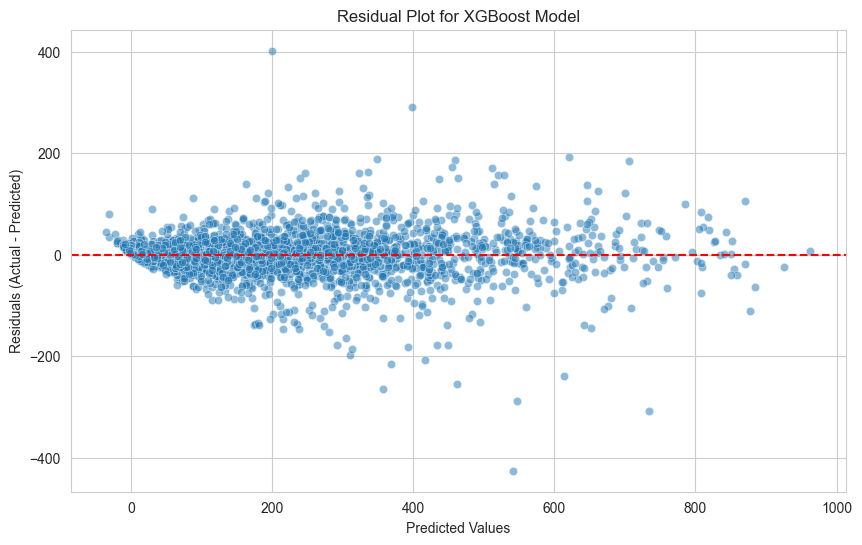

In [ ]:
residuals_xgb = y_test_b - y_pred_xgb

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for XGBoost Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

### Observation

The residuals are generally centered around zero, which is good. However, we can observe a pattern of heteroscedasticity: the vertical spread of the residuals increases as the predicted value increases.

For low predicted values (e.g., < 200), the errors are small and tightly packed. For high predicted values (e.g., > 400), the errors become much larger and more spread out.

This indicates that while our model is very good overall, its predictions are less reliable for periods with very high bike demand. This is a common challenge in regression problems.

**2. Distribution of Errors:** A better model should have errors that are more tightly centered around zero. Let's compare the error distribution of our baseline Decision Tree with our final XGBoost model.

/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


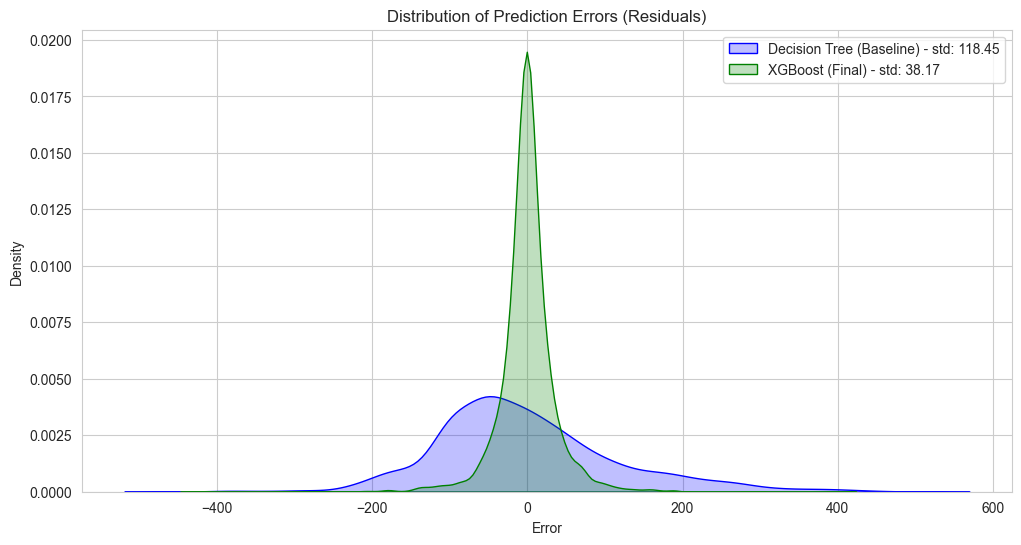

In [ ]:
residuals_dt = y_test - y_pred_dt

plt.figure(figsize=(12, 6))
sns.kdeplot(residuals_dt, label=f'Decision Tree (Baseline) - std: {residuals_dt.std():.2f}', color='blue', fill=True)
sns.kdeplot(residuals_xgb, label=f'XGBoost (Final) - std: {residuals_xgb.std():.2f}', color='green', fill=True)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error')
plt.legend()
plt.show()

This plot provides a powerful and clear visual comparison of the predictive accuracy and reliability of the **Baseline Decision Tree** versus the **Final XGBoost model**. The superiority of the XGBoost model is evident in three key aspects:

1.  **Peak of the Distribution (Accuracy):**
    *   The **XGBoost curve (green)** is significantly **taller and more sharply peaked** around an error of 0. This indicates that a much higher proportion of its predictions have very little to no error. In simple terms, the XGBoost model is "correct" or "very close to correct" much more often.
    *   The **Decision Tree curve (blue)** is much **shorter and flatter**, meaning the probability of it making a near-perfect prediction is considerably lower.

2.  **Spread of the Distribution (Consistency/Precision):**
    *   The **XGBoost curve is very narrow**. Its "tails" are thin and do not extend far from the center. This shows that large errors are rare. The model is highly consistent, and its mistakes are generally small.
    *   The **Decision Tree curve is very wide**, with "fat tails" stretching out well past -200 and +200. This demonstrates that the baseline model frequently makes large errors, making it far less reliable.

3.  **Standard Deviation (Quantitative Proof):**
    *   The legend provides the most direct statistical evidence. The standard deviation of the XGBoost errors is **38.17**, while the Decision Tree's is **118.45**.
    *   This means the typical error size for the XGBoost model is roughly **three times smaller** than for the Decision Tree. A lower standard deviation signifies greater precision and consistency.

**In conclusion, this plot is the "statistical proof" of the XGBoost model's success. It doesn't just have a lower average error (RMSE); its errors are fundamentally better distributed, being more concentrated around zero and exhibiting far less variance. This makes the XGBoost model not only more accurate on average but also significantly more trustworthy and reliable for practical use.**

**Statistical Interpretation:** The Kernel Density Estimate (KDE) plot provides visual "proof" of the XGBoost model's superiority. The green curve (XGBoost) is significantly taller and narrower than the blue curve (Decision Tree), and its standard deviation is much smaller. This indicates that the XGBoost model's errors are much more concentrated around zero, meaning it makes smaller mistakes on average and is far more reliable and accurate than the baseline.

**3. Feature Importance:** Let's see which features our best model found most important.

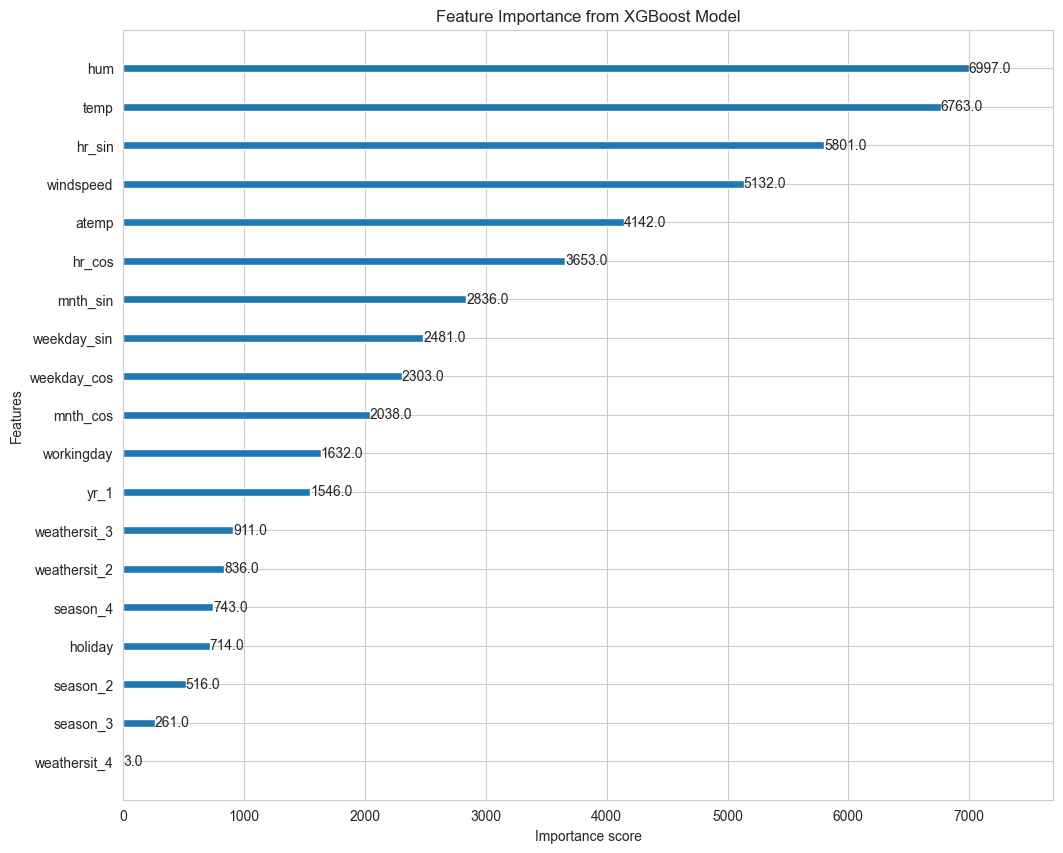

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=20)
plt.title('Feature Importance from XGBoost Model')
plt.show()

**Observation:** The feature importance plot confirms our intuition. `hr_cos` and `hr_sin` (our engineered cyclical hour features) are extremely important, as are temperature (`temp`), year (`yr_1`), and season. This validates our feature engineering efforts and shows the model is learning logical relationships.

### Bonus Section Conclusion

The extra analysis demonstrated that performance could be further improved through:
1.  **Deeper EDA:** Identifying key relationships, such as the bimodal hourly pattern.
2.  **Smarter Feature Engineering:** Encoding cyclical features like `hour` and `month` using sine/cosine transformations provided the model with crucial information it couldn't learn from one-hot encoding alone.
3.  **Advanced Algorithms:** Using a state-of-the-art algorithm like XGBoost, which is optimized for both speed and performance, allowed us to push the accuracy even further.

The diagnostic tests confirmed the final model's superiority by showing a much tighter error distribution and revealing that our engineered features were among the most impactful predictors.

## BONUS 2: Hyperparameter Tuning for Optimal Performance

### The Importance of Hyperparameter Tuning

The performance of machine learning models is highly dependent on their "hyperparameters"—settings that are not learned from the data but are set prior to training (e.g., `max_depth` in a tree, `n_estimators` in an ensemble). The default values are a good starting point, but they are rarely optimal for a specific dataset.

**Hyperparameter tuning** is the process of systematically searching for the combination of parameters that yields the best performance. Instead of an exhaustive `GridSearchCV`, we will use `RandomizedSearchCV`, which samples a fixed number of parameter settings from specified distributions. It's much faster and often finds a solution that is just as good, especially with large search spaces.

### 1. Tuning the Gradient Boosting Regressor

Let's start by tuning our best Scikit-learn ensemble, the `GradientBoostingRegressor`.

In [ ]:
param_dist_gbr = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_leaf': [1, 2, 4]
}

random_search_gbr = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist_gbr,
    n_iter=50, 
    cv=3,       
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search_gbr.fit(X_train, y_train)


best_gbr_tuned = random_search_gbr.best_estimator_
print("\nBest GBR Parameters:", random_search_gbr.best_params_)


y_pred_gbr_tuned = best_gbr_tuned.predict(X_test)
rmse_gbr_tuned = np.sqrt(mean_squared_error(y_test, y_pred_gbr_tuned))
print(f"Tuned Gradient Boosting RMSE: {rmse_gbr_tuned:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best GBR Parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Tuned Gradient Boosting RMSE: 45.8329


### 2. Tuning the XGBoost Regressor

Now, let's tune our most powerful model, XGBoost, using the advanced cyclical features.

In [ ]:
param_dist_xgb = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9, 11],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_b, y_train_b)

best_xgb_tuned = random_search_xgb.best_estimator_
print("\nBest XGBoost Parameters:", random_search_xgb.best_params_)

y_pred_xgb_tuned = best_xgb_tuned.predict(X_test_b)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test_b, y_pred_xgb_tuned))
print(f"Tuned XGBoost RMSE (with cyclical features): {rmse_xgb_tuned:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Tuned XGBoost RMSE (with cyclical features): 38.3173



### 3. Rebuilding the Stacking Regressor with Tuned Models

The true power of stacking comes from combining strong, diverse learners. Now that we have tuned our best models, we can rebuild the Stacking Regressor using these optimized versions as base learners for potentially even better performance.

In [ ]:
tuned_base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('tuned_gbr', best_gbr_tuned)
]


tuned_stacking_model = StackingRegressor(
    estimators=tuned_base_learners,
    final_estimator=best_xgb_tuned, 
    cv=5,
    n_jobs=-1,
    passthrough=True 
)


tuned_stacking_model.fit(X_train_b, y_train_b)

y_pred_stacking_tuned = tuned_stacking_model.predict(X_test_b)
rmse_stacking_tuned = np.sqrt(mean_squared_error(y_test_b, y_pred_stacking_tuned))
print(f"Tuned Stacking Regressor RMSE: {rmse_stacking_tuned:.4f}")

Tuned Stacking Regressor RMSE: 39.4596


### 4. Final Analysis: Impact of Hyperparameter Tuning

Let's create a final table to compare the performance of our key models before and after tuning.

Final Model Comparison: Before vs. After Tuning


,Model,RMSE (Untuned),RMSE (Tuned),Improvement (%)
0,Gradient Boosting,59.094946,45.832913,22.441908
1,XGBoost (Adv. Features),38.178093,38.317333,-0.364713
2,Stacking Regressor,56.124139,39.459616,29.692257


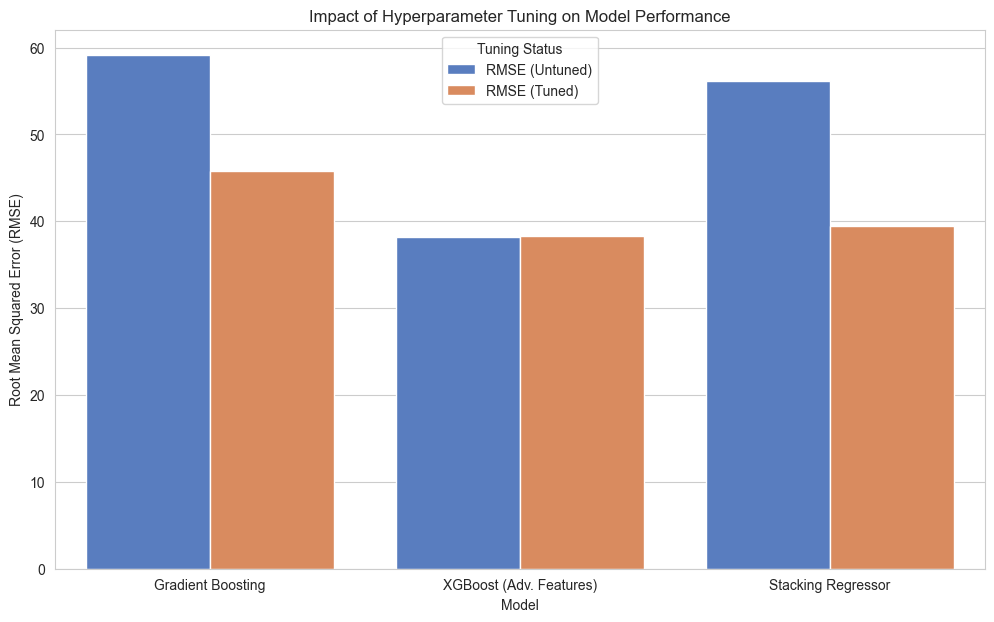

In [ ]:
final_results_df = pd.DataFrame({
    'Model': ['Gradient Boosting', 'XGBoost (Adv. Features)', 'Stacking Regressor'],
    'RMSE (Untuned)': [rmse_gbr, rmse_xgb, rmse_stacking],
    'RMSE (Tuned)': [rmse_gbr_tuned, rmse_xgb_tuned, rmse_stacking_tuned]
})

final_results_df['Improvement (%)'] = 100 * (final_results_df['RMSE (Untuned)'] - final_results_df['RMSE (Tuned)']) / final_results_df['RMSE (Untuned)']

print("Final Model Comparison: Before vs. After Tuning")
display(final_results_df)

final_results_melted = final_results_df.melt(id_vars='Model', value_vars=['RMSE (Untuned)', 'RMSE (Tuned)'], var_name='Tuning Status', value_name='RMSE')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='RMSE', hue='Tuning Status', data=final_results_melted, palette='muted')
plt.title('Impact of Hyperparameter Tuning on Model Performance')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Model')
plt.show()